# Wind Direction

To find the average wind direction we cannot simply use .mean().  350 and 010 are the same distance from 000/360, but they affect the mean in very different amounts so we must use trigonometry to find average directions. 

Direction is sometimes best visualized on a wind rose so we will set up some functions to plot wind roses with average wind directions.

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

Get all the libraries we'll need for this project then read in some wind data collected and cleaned from [IGRA](https://www.ncdc.noaa.gov/data-access/weather-balloon/integrated-global-radiosonde-archive) using make_csv.py and clean_igra.py.  

We will use data from the Oakland, CA station in 2019.

In [8]:
oak = pd.read_csv('OAK_2019.csv', index_col = 0)
oak.head()

,year,month,day,hour,rel_time,p_src,np_src,lat,long,lvl_1,...,gph,zflag,temp,tflag,rh,dew_drop,wdir,wspd,cardinal,press_alt_ft
0,2019,1,1,0,2303,ncdc-nws,ncdc-nws,377444,-1222236,2,...,3.0,C,13.2,B,28.0,18.1,29.0,108.0,NE,-68
1,2019,1,1,0,2303,ncdc-nws,ncdc-nws,377444,-1222236,1,...,133.0,B,12.0,B,23.9,20.0,22.0,122.0,N,364
2,2019,1,1,0,2303,ncdc-nws,ncdc-nws,377444,-1222236,1,...,778.0,B,5.9,B,24.5,18.8,15.0,136.0,N,2499
3,2019,1,1,0,2303,ncdc-nws,ncdc-nws,377444,-1222236,2,...,783.0,B,5.8,B,24.5,18.8,15.0,136.0,N,2517
4,2019,1,1,0,2303,ncdc-nws,ncdc-nws,377444,-1222236,2,...,1416.0,B,0.0,B,29.8,15.6,20.0,127.0,N,4627


## Clean the data 
We're interested in wind direction and wind speed  
* Get rid of any rows with missing wind values
* Convert wind speed to knots
* We'll just look at the data for one pressure altitude,  700mb which is about 10,000 feet.

In [9]:
# Drop rows with missing wind information
oak.dropna(subset=['wspd'], inplace=True)
oak.wdir.isnull().sum()
# we can see that getting rid of missing speed rows also got rid of missing directions

0

In [10]:
# Convert to knots, original data is in tenths of meters per second
oak.wspd = oak.wspd.apply(lambda x: round(x * 0.194384, 2))
oak.wspd.value_counts()

7.97      390
9.91      388
12.05     387
11.08     384
6.03      380
         ... 
167.17      1
132.96      1
143.84      1
111.77      1
157.45      1
Name: wspd, Length: 731, dtype: int64

In [11]:
# Use data from the 700mb soundings 
df = oak[oak.pressure == 700]
df.shape

(719, 24)

## Make some charts to get a feel for our data  

We'll make some histograms of speed and direction to see how the data is distributed.

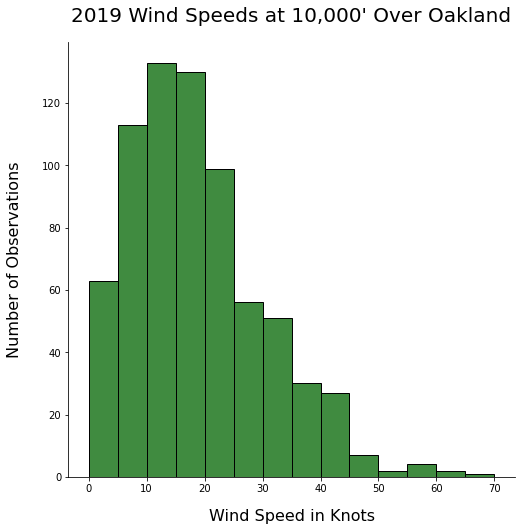

In [12]:
f, ax = plt.subplots(figsize=(8,8))

# create bins for every 5 knots and align the ticks with the edges
bins = np.arange(0, df.wspd.max()+1, 5)

# create the histogram
ax = sns.histplot(data=df, x='wspd', bins=bins, color='darkgreen')

# Apply some labels and padding and give the plot a cleaner look
ax.set_xlabel('Wind Speed in Knots', fontsize=16, labelpad=15)
ax.set_ylabel('Number of Observations', fontsize=16, labelpad = 20)
ax.set_title('2019 Wind Speeds at 10,000\' Over Oakland', fontsize=20, pad=20)

sns.despine()

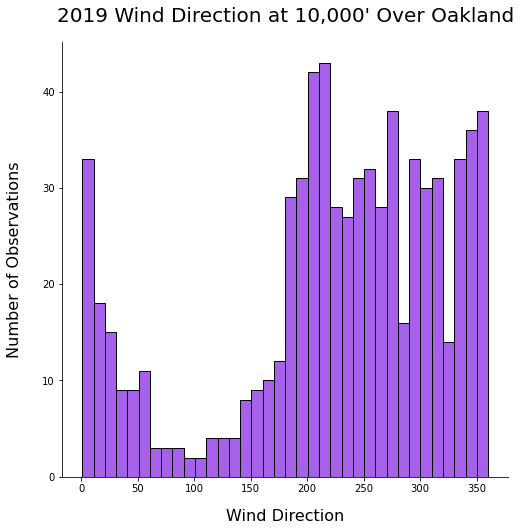

In [13]:
f, ax = plt.subplots(figsize=(8,8))
# plot the wind direction histogram with bins for every 10 degrees on the compass
ax = sns.histplot(data=df, x='wdir', bins=36, color='blueviolet')

# clean up the look and apply labels
ax.set_xlabel('Wind Direction', fontsize=16, labelpad=15)
ax.set_ylabel('Number of Observations', fontsize=16, labelpad = 20)
ax.set_title('2019 Wind Direction at 10,000\' Over Oakland', fontsize=20, pad=20)

sns.despine()

We can see that windspeed at 10,000 ft is right skewed with the majority of observations under 30kts.  The wind appears to mostly come from the west through the north.  There are very few observations from the east and south.  From these histogrmas we now have an idea of what a wind rose from this data may look like. 

## Find how the wind speed and direction change over the year
* Break data down by month
* find average speed each month
* find average direction each month
* plot those results on a wind rose

In [14]:
# create a dataframe with the average wind speed for each month
monthly_df = pd.DataFrame(df.groupby('month').wspd.mean())
monthly_df.head()

,wspd
month,
1,27.858833
2,31.913571
3,21.120820
4,21.002881
5,17.441452


### To find average direction: 
Use numpy [trigonometry](https://www.w3schools.com/python/numpy_ufunc_trigonometric.asp) to apply this [mean of angles equation](https://en.wikipedia.org/wiki/Mean_of_circular_quantities). 
* sins = sum sins of all angles divided by N (number of data points)
* coss = sum cosines of all angles divided by N
* arctan(sins/coss)
    * \+ 180 if coss < 0
    * \+ 360 if sins < 0 and coss > 0 


In [15]:
def average_direction(df):   
    '''
    Input a data frame with 'month' and 'wdir' columns.
    Return a series with average wind direction for each month 
    '''
    avg_dir = {}
    # Loop through each month
    for month in df.month.unique():
        # Turn all the wdir values for the month into an array.
        df_month = df[df.month == month]
        direction = np.array(df_month.wdir)
        
        # Turn that array into radians.
        direction = np.deg2rad(direction)
        
        # Apply the trigonomic equation.
        sins = np.sin(direction).sum() 
        sins /= len(direction)
        coss = np.cos(direction).sum() 
        coss /= len(direction)
        average = np.arctan(sins/coss)
        
        # Turn it back into degrees and add correction if it meets the criteria.
        average = np.rad2deg(average)
        if coss < 0: 
            x = 180 
        elif sins < 0:
            x = 360 
        else: x = 0
        average += x
        
        # Store the average wind direction for that month in the dictionary
        avg_dir[month] = average
    
    # Create a series of all the monthly average wind directions
    averages = pd.Series(avg_dir)
   
    return averages

In [16]:
# create a column in our average dataframe for wind direction using the average_direction function
monthly_df['wdir'] = average_direction(df)
# get out of multilevel index and give 'month' its own column
monthly_df = monthly_df.reset_index()
monthly_df

,month,wspd,wdir
0,1,27.858833,258.189731
1,2,31.913571,268.980040
2,3,21.120820,250.594750
3,4,21.002881,294.285084
4,5,17.441452,312.266252
5,6,13.645500,309.528183
6,7,10.799016,237.216988
7,8,9.791613,220.496161
8,9,17.231833,278.842084
9,10,17.516066,320.573549


## WIND ROSES

* Convert the direction into radians for plotting
* Rotate the axis so that north is on top and direction goes clockwise for a familiar compass rose layout
* theta is the direction
* radii is how long the vector is (speed in this case)
* width is how thick you want each vector to be

In [17]:
def rose_axis_settings(ax):
    '''
    Input an axis for a plot and this function will turn it into a compass rose layout
    '''
    ax.set_theta_direction('clockwise')
    ax.set_theta_zero_location('N')
    ax.set_xticklabels(['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW'])   

In [21]:
def plot_wind_rose(df, size):   
    '''
    Input a dataframe with 'month', 'wdir', and 'wspd' columns.
    Input a size for each vector.  The larger the number the skinnier the vectors.
    Creates a wind rose plot showing direction and speed of wind each month.
    '''
    fig, ax = plt.subplots(figsize=(8,8))
    ax = plt.subplot(111, polar=True)

    # Compute the bars based on direction and speed
    # Convert direction to radians for placement on the compass
    theta = np.radians(df.wdir)
    # length of vector based on speed
    radii = df.wspd
    # Width for the pie slices 
    # User inputs a size.  The larger the number, the smaller the vectors will be
    width = np.radians(360.0/size)
    # set labels for the legend based on month
    labels = df.month
    # Choose a color for each month
    colors=['m', 'g', 'r', 'y', 'k', 'c', 'b', 'lime', 'orange', 'grey', 'navy', 'pink']

    # Create each pie piece based on direction, speed and the width we set above
    bars = ax.bar(theta, radii, width=width, bottom=0.0)

    # Plot the vectors with a color and a label for the legend
    for bar, label, color in zip(bars, labels, colors):
        bar.set_facecolor(color)
        bar.set_alpha(0.6)
        bar.set_label(label)

    # set the legend to the right side so it won't obscure the chart
    ax.legend(bbox_to_anchor=(1.1, 1), title='Month')

    # Get the compass rose layout for this plot
    rose_axis_settings(ax)

    # Put on a title
    ax.set_title('Oakland 10,000\' Average Wind Direction Each Month of 2019', fontsize=20, pad=20)

    plt.show()

<ipython-input-17-c63ecc28fc41>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW'])


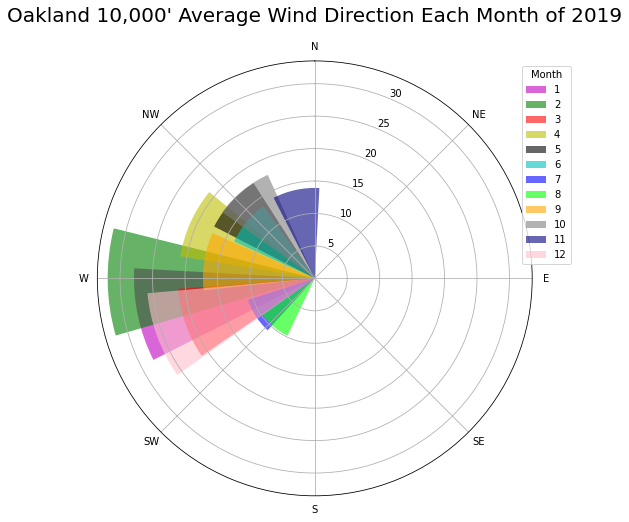

In [22]:
plot_wind_rose(monthly_df, 12)

## Finished
* We found the average speed and direction for each month of 2019 at 10,000 feet.
* We then created a wind rose for easy visualization of the monthly average wind speed and direction.